In [1]:
import pandas as pd
import numpy as np 
import plotly.express as px
import plotly.graph_objects as go 
import seaborn as sns 
import pingouin as pg
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, auc, log_loss, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind

import optuna

### Carregar Dados

In [2]:
# Carregar DF
df_star = pd.read_csv(r'datasets\pulsar.csv')

In [3]:
# Visualizar DF
df_star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Mean of the integrated profile                17898 non-null  float64
 1   Standard deviation of the integrated profile  17898 non-null  float64
 2   Excess kurtosis of the integrated profile     17898 non-null  float64
 3   Skewness of the integrated profile            17898 non-null  float64
 4   Mean of the DM-SNR curve                      17898 non-null  float64
 5   Standard deviation of the DM-SNR curve        17898 non-null  float64
 6   Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7   Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                  17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [4]:
# Visualizar 10 primeiras linhas
df_star.head(10)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
5,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,0
6,119.484375,48.765059,0.031460,-0.112168,0.999164,9.279612,19.206230,479.756567,0
7,130.382812,39.844056,-0.158323,0.389540,1.220736,14.378941,13.539456,198.236457,0
8,107.250000,52.627078,0.452688,0.170347,2.331940,14.486853,9.001004,107.972506,0
9,107.257812,39.496488,0.465882,1.162877,4.079431,24.980418,7.397080,57.784738,0


In [5]:
df_star.isna().sum()

Mean of the integrated profile                  0
Standard deviation of the integrated profile    0
Excess kurtosis of the integrated profile       0
Skewness of the integrated profile              0
Mean of the DM-SNR curve                        0
Standard deviation of the DM-SNR curve          0
Excess kurtosis of the DM-SNR curve             0
Skewness of the DM-SNR curve                    0
target_class                                    0
dtype: int64

### EDA

In [6]:
# Distribuição da variável target 
df_star.value_counts('target_class') / len(df_star) * 100 

target_class
0    90.842552
1     9.157448
Name: count, dtype: float64

In [7]:
df_star = df_star.rename(columns={'Mean of the integrated profile': 'media_intensidade_sinal_ao_longo_do_tempo', 
                                  'Standard deviation of the integrated profile': 'variacao_intensidade_em_torno_da_media', 
                                  'Excess kurtosis of the integrated profile': 'cauda_da_distribuicao_do_sinal', 
                                  'Skewness of the integrated profile': 'grau_de_distorcao_da_distribuicao_do_sinal_em_torno_da_media',
                                  'Mean of the DM-SNR curve': 'intensidade_media_do_sinal',
                                  'Standard deviation of the DM-SNR curve': 'variabilidade_da_razão_sinal_ruido',
                                  'Excess kurtosis of the DM-SNR curve': 'presença_de_picos_extremos_na_distribuicao_da_razao_sinal_ruido',
                                  'Skewness of the DM-SNR curve': 'inclinacao_da_distribuicao_da_razao_sinal_ruido_em_relacao_a_media',
                                  'target_class': 'isPulsare'                        
                                  })

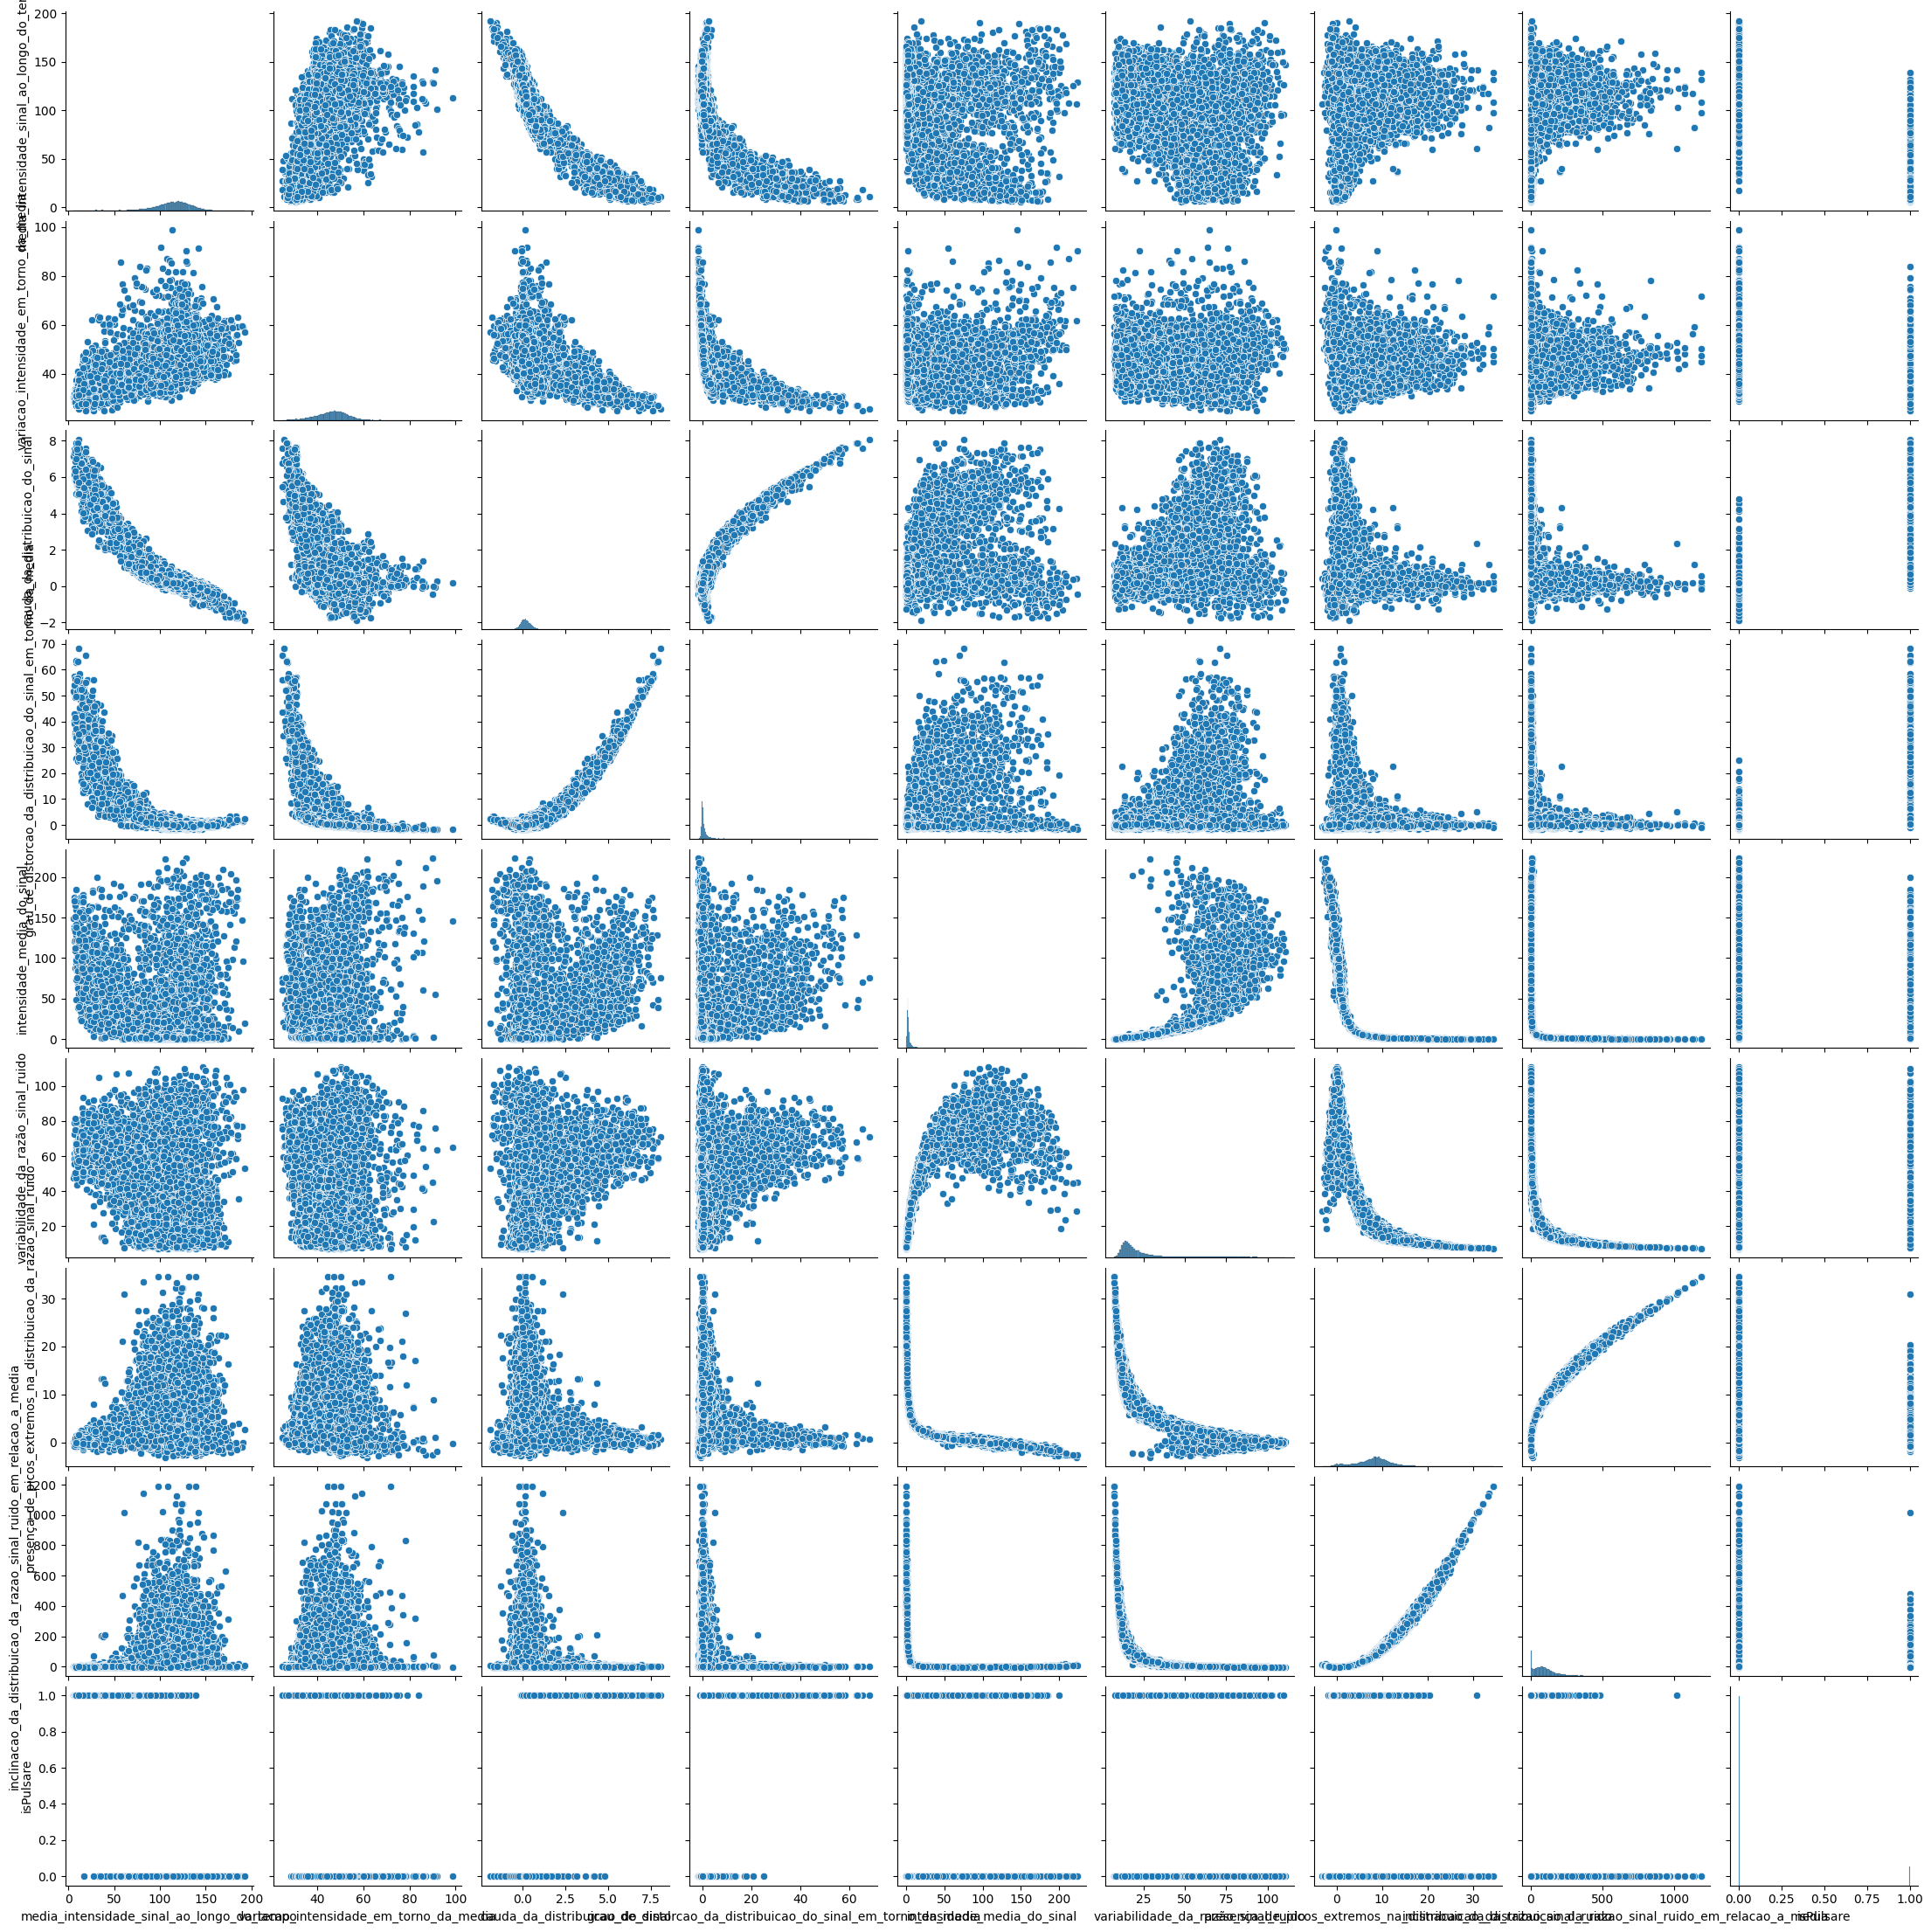

In [8]:
# Verificar distribuição e correlacao das features                
sns.pairplot(df_star, diag_kind='hist')

<Axes: >

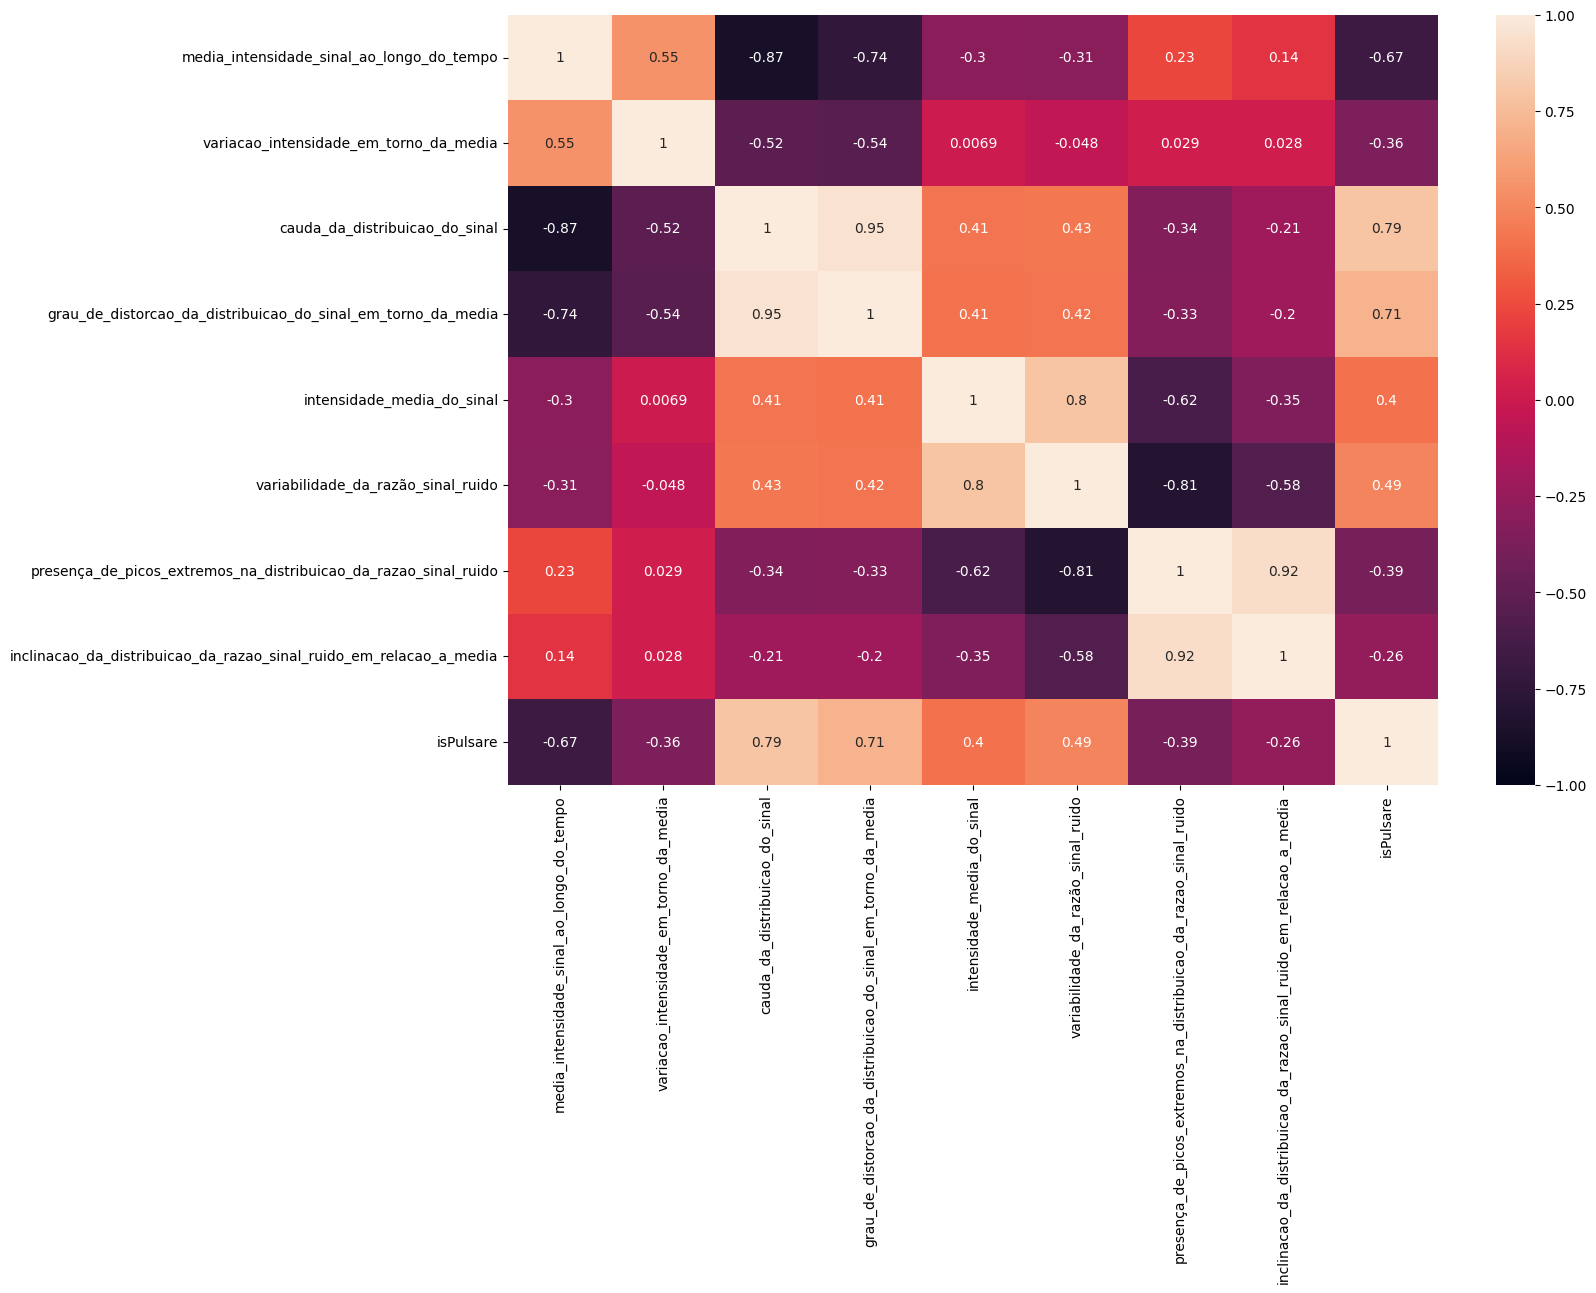

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(df_star.corr(), vmin=-1, vmax=1, annot=True)

### Treinar modelo

In [10]:
X = df_star.drop(columns=['isPulsare'], axis=1)
y = df_star.isPulsare

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=51)

model_lr = LogisticRegression(solver='liblinear')

model_lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [11]:
# Retornar a qualissificação predita com base no conjunto de testes
y_pred = model_lr.predict(X_test)

In [12]:
# Decision function retorna o valo calculado de cada instância considerando os coeficientes obtidos na regressão
y_decision = model_lr.decision_function(X_test)

In [13]:
# Retornar as probabilidades de cada classe para cada instância no conjunto de testes
y_prob = model_lr.predict_proba(X_test)

In [14]:
# Retornar os valores da curva ROC - TPR (True Positive Rate), FPR (False Positive Rate), Threshold
fpr, tpr, thresholds = roc_curve(y_test, y_decision)

In [15]:
# Calcular AUC(Area Under the Curve) com base nos valores da curva ROC
roc_auc = auc(fpr, tpr)
roc_auc

0.9811483662734088

Uma vez que a AUC se aproxima de 1, temos que o modelo está classifcando muito bem as classes

In [16]:
# Plotar Curva ROC com o valor de AUC
fig = px.area(
    x=fpr, y=tpr,
    title=f'Curva ROC(AUC={roc_auc:.4f})',
    labels=dict(x='FPR', y='TPR'),
    width=700, height=500
)
fig.add_shape(
    type='line', line= dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [17]:
# Apresentar a importância das features (com base nos coeficientes obtidos na regressão)

importance = np.abs(model_lr.coef_)

# Exibir a importância das features 
print("Importância das features")
for i, feature in enumerate(model_lr.feature_names_in_):
    print(f"{feature}: {importance[0][i]}")

Importância das features
media_intensidade_sinal_ao_longo_do_tempo: 0.0030437355564224625
variacao_intensidade_em_torno_da_media: 0.03911779715878316
cauda_da_distribuicao_do_sinal: 5.113061532497208
grau_de_distorcao_da_distribuicao_do_sinal_em_torno_da_media: 0.4976008135867275
intensidade_media_do_sinal: 0.02188507699730806
variabilidade_da_razão_sinal_ruido: 0.027251894496783093
presença_de_picos_extremos_na_distribuicao_da_razao_sinal_ruido: 0.16841444879795114
inclinacao_da_distribuicao_da_razao_sinal_ruido_em_relacao_a_media: 0.00082834897538051


Temos que a feature cauda_da_distribuicao_do_sinal é a mais importante para a classificacao da isPulsare, como já havia sido visto na analise de correlação

In [18]:
# F1-score

f1_score_model = f1_score(y_test, y_pred)
f1_score_model

0.8813209494324046

In [19]:
# Apresentar o BCE (Binary Cross Entropy) - Log Loss
log_loss(y_test, y_pred)

0.7718845697855632

Temos um log loss de 0.77, temos uma interpretação intermediaria, ou seja ainda há casos que ele erra ou é pouco confiante em alguns

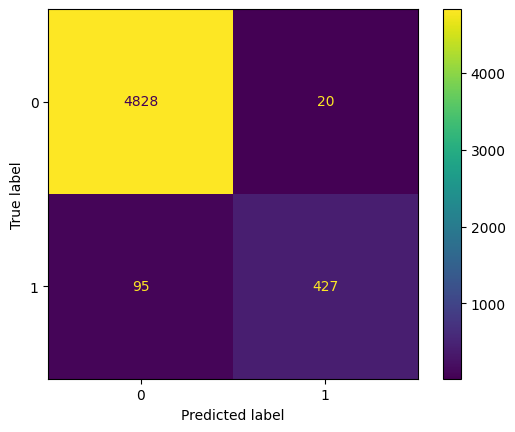

In [20]:
# Mostrar Matrix de Confusão
confusion_matrix_modelo = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix_modelo)
disp.plot()

Pela análise do gráfico vimos que o modelo errou um total de 115 casos de 5370

### Otimizar Hiperparametros com Optuna

In [21]:
# Ajustar hiperparâmetros com optuna

# Hiperparametro penalty
# Regularização controla a complexidade do modelo, reduzindo o Overfitting
# L1(Ridge) Útil para fins de Feature Selection e para modelo esparsos. Soma dos valores absolutos dos coeficientes do seu modelo
# L2(Lasso) Útil para evitar o Overfitting, principalmente quando há multicolinearidade. Soma dos quadrados dos coeficientes

# Hiperparametro C
# Valores maiores que C, ele indica uma regularização mais fraca
# Valores menores que C, indica uma regularização mais forte

def lr_optuna(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    c_values = trial.suggest_categorical('c', [100,10,1,0.1,0.01])
    
    # Treinar o modelo
    modelo_lr_optuna = LogisticRegression(solver='liblinear', penalty=penalty, C=c_values)
    modelo_lr_optuna.fit(X_train, y_train)
    
    # Retornar a Decision Function
    y_decision_optuna = modelo_lr_optuna.decision_function(X_test)
    
    # Calcular a curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_decision_optuna)
    
    # Calcular AUC
    roc_auc_optuna = auc(fpr, tpr)
    
    # Retornar predicao
    y_pred_optuna = modelo_lr_optuna.predict(X_test)
    
    # Calcular F1Score
    f1_score_optuna = f1_score(y_test, y_pred_optuna, average='macro')
    
    # Calcular o BCE - Erro
    log_loss_optuna = log_loss(y_test, y_pred_optuna)
    
    return roc_auc_optuna, f1_score_optuna, log_loss_optuna

In [24]:
# Criacao de estudo e rodar otimizador
search_space = {'penalty': ['l1','l2'], 'c': [100,10,1,0.1,0.01]}
sampler = optuna.samplers.GridSampler(search_space=search_space)
estudo_lr = optuna.create_study(directions=['maximize', 'maximize', 'minimize'])
estudo_lr.optimize(lr_optuna, n_trials=20)

[I 2025-11-03 12:35:58,827] A new study created in memory with name: no-name-17784fe2-1d68-4efd-9054-d6dffd014e58
[I 2025-11-03 12:35:58,911] Trial 0 finished with values: [0.9754020301455433, 0.9221858973915331, 0.8994133247936126] and parameters: {'penalty': 'l2', 'c': 0.01}.
[I 2025-11-03 12:35:59,328] Trial 1 finished with values: [0.981828427095583, 0.9391416108689666, 0.7249002916247027] and parameters: {'penalty': 'l1', 'c': 10}.
[I 2025-11-03 12:35:59,973] Trial 2 finished with values: [0.9818363301847426, 0.9385214069085037, 0.7316123313619686] and parameters: {'penalty': 'l1', 'c': 10}.
[I 2025-11-03 12:36:00,091] Trial 3 finished with values: [0.9812736302365869, 0.9403785556364166, 0.7114762121501712] and parameters: {'penalty': 'l2', 'c': 10}.
[I 2025-11-03 12:36:00,598] Trial 4 finished with values: [0.9818489751273978, 0.9391416108689666, 0.7249002916247028] and parameters: {'penalty': 'l1', 'c': 10}.
[I 2025-11-03 12:36:01,107] Trial 5 finished with values: [0.981849765

In [25]:
# Mostrar melhor resultado e melhor conjunto de hiperparametros
melhor_trial = max(estudo_lr.best_trials, key=lambda t:t.values[1])
print(f"Trial com melhor AUC e F1 e menor BCE")
print(f"\tnumber: {melhor_trial.number}")
print(f"\tnumber: {melhor_trial.params}")
print(f"\tnumber: {melhor_trial.values}")

Trial com melhor AUC e F1 e menor BCE
	number: 3
	number: {'penalty': 'l2', 'c': 10}
	number: [0.9812736302365869, 0.9403785556364166, 0.7114762121501712]


O modelo 3 com esses valores conseguiu aumentar o f1-score ao comparar com o outro modelo e baixou o BCE de 0.77 para 0.71

### Criando Best Model

In [34]:
model_best_lr = LogisticRegression(penalty='l2', C=10, solver='liblinear', random_state=51)
model_best_lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,51
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
y_pred_best = model_best_lr.predict(X_test)
y_decision_best = model_best_lr.decision_function(X_test)
y_prob = model_best_lr.predict_proba(X_test)

5370 5370


In [40]:
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_decision_best)
roc_auc_best = auc(fpr_best, tpr_best)
roc_auc_best

0.9812736302365869

Houve um aumento sutil na AUC

In [41]:
importance = np.abs(model_best_lr.coef_)

# Exibir a importância das features 
print("Importância das features")
for i, feature in enumerate(model_best_lr.feature_names_in_):
    print(f"{feature}: {importance[0][i]}")

Importância das features
media_intensidade_sinal_ao_longo_do_tempo: 0.012950615326571728
variacao_intensidade_em_torno_da_media: 0.046894137218779906
cauda_da_distribuicao_do_sinal: 5.780154475787044
grau_de_distorcao_da_distribuicao_do_sinal_em_torno_da_media: 0.5736449652977463
intensidade_media_do_sinal: 0.022170920535240474
variabilidade_da_razão_sinal_ruido: 0.022794655563576818
presença_de_picos_extremos_na_distribuicao_da_razao_sinal_ruido: 0.20327536325783307
inclinacao_da_distribuicao_da_razao_sinal_ruido_em_relacao_a_media: 0.0019039838190316372


A feature mais importante continuou sendo a cauda_da_distribuicao_do_sinal

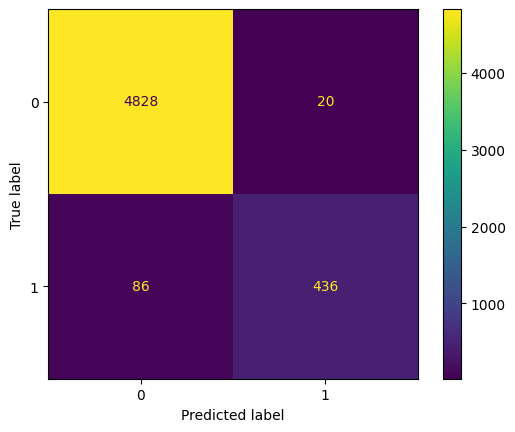

In [42]:
confusion_matrix_modelo_best = confusion_matrix(y_test, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix_modelo_best)
disp_best.plot()

Houve uma diminuição de 9 casos de falso positivos para o modelo sem a otimizacao de parametros

Temos que o modelo gerado com a otimizacao de hiperparametros esta classificando bem em relaçao a variaverl target